In [1]:

import sys
sys.path.append('/home/paperspace/Desktop/DL_Project/py_files')

import data_preparation
import model_evaluation
import deepchem as dc
from deepchem import models
from deepchem.models import GraphConvModel
import matplotlib.pyplot as plt
from matplotlib import ticker
from openpyxl import Workbook
from functools import partial
import os
import pandas as pd
import pickle
import numpy as np
from datetime import datetime
import torch
import time
from pytz import timezone
import random
from sklearn.metrics import log_loss
import json
import warnings
warnings.filterwarnings('ignore')


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/paperspace/.local/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [2]:
def dc_metrics() -> list:
    '''
    adfdf
    '''
    # metrics to log throughout training
    m1 = dc.metrics.Metric(dc.metrics.roc_auc_score)
    m2 = dc.metrics.Metric(dc.metrics.accuracy_score)
    m3 = dc.metrics.Metric(dc.metrics.balanced_accuracy_score)

    return [m1, m2, m3]

In [3]:
def define_parameters() -> dict:
    """
    Based on the specified choices, randomly select the parameters for the current model iteration.
    
    Returns:
    dictionary with keys representing the parameter id and the values as the parameter
    """
    graph_conv_layers_options = [
                                [64, 64]
                                ]

    batchnorm_options = [True]
    dropout_options = [0]
    dense_layer_size_options = [128]
    # dense_layer_size_options=[128]
    batch_size_options = [500]
    epoch_list = [10]

    parameters={}

    parameters['probability_threshold']=0.2
    parameters['batch_size']=random.choice(batch_size_options)
    parameters['graph_conv_layers']=random.choice(graph_conv_layers_options)
    parameters['batchnorm']=random.choice(batchnorm_options)
    parameters['dropout']=random.choice(dropout_options)
    parameters['dense_layer_size']=random.choice(dense_layer_size_options)
    parameters['epochs']=20

    return parameters

In [5]:
def define_final_parameters(target: str) -> dict:
    """
    Based on the specified target, load the optimal architecture.
    """
    with open('/home/paperspace/Desktop/DL_Project/data/final_model_params.json', 'r') as f:
        model_params=json.load(f)

    target_specific_params=model_params[target]

    return target_specific_params

In [52]:
df = data_preparation.load_data(testing=False)
df.head()

1,589 compounds inhibit APP
1,024 compounds inhibit Tau


,pubchem_cid,smiles,tau_inhibitor,app_inhibitor,inchi,inchikey,cmpdname,isosmiles,cmpdsynonym,mw,...,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,morgan_fp,dc_graph,app_label,tau_label
0,2227226,C1=CC=C(C=C1)OC(=O)C2=CC=CC3=C2N=CC=C3,Inactive,Inactive,InChI=1S/C16H11NO2/c18-16(19-13-8-2-1-3-9-13)1...,GPMDYHKFDVDMLK-UHFFFAOYSA-N,8-Quinolinecarboxylic acid phenyl ester,C1=CC=C(C=C1)OC(=O)C2=CC=CC3=C2N=CC=C3,phenyl quinoline-8-carboxylate|8-quinolinecarb...,249.26,...,312.0,3.6,19,0,3,3,0000000000000000000000000000000000000000000000...,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,0
1,135420967,COC1=CC=C(C=C1)N=CC2=C(C3=CC=CC=C3OC2=O)O,Inactive,Inactive,InChI=1S/C17H13NO4/c1-21-12-8-6-11(7-9-12)18-1...,RUCHDIHJKMGHHH-UHFFFAOYSA-N,"3-[(4-methoxyanilino)methylene]-2H-chromene-2,...",COC1=CC=C(C=C1)N=CC2=C(C3=CC=CC=C3OC2=O)O,364602-08-4|AGN-PC-0LQKC2|Oprea1_586022|MLS000...,295.29,...,477.0,2.8,22,1,5,3,0000000000000000000000000000000000000000000000...,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,0
2,15945137,C1CCN(CC1)CC(=O)C2=CC=C(C=C2)OC(F)F.Br,Inactive,Inactive,InChI=1S/C14H17F2NO2.BrH/c15-14(16)19-12-6-4-1...,RBJGPSFQVZUNKQ-UHFFFAOYSA-N,1-[4-(Difluoromethoxy)phenyl]-2-piperidin-1-yl...,C1CCN(CC1)CC(=O)C2=CC=C(C=C2)OC(F)F.Br,MLS000392681|CHEMBL1301972|SMR000261595,350.20,...,285.0,NaN,20,1,5,5,0110000000000000000000000000000000000000000000...,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,0
3,7191270,CCOC(=O)CNC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=C(C=C2)C,Inactive,Inactive,InChI=1S/C16H18N4O4S2/c1-3-24-13(22)8-17-12(21...,QICJAPDRGJFGEK-UHFFFAOYSA-N,"Ethyl 2-[[2-[[5-[(4-methylbenzoyl)amino]-1,3,4...",CCOC(=O)CNC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=C(C=C2)C,MLS000624325|893337-54-7|SMR000323633|ethyl 2-...,394.50,...,501.0,2.4,26,2,8,9,0000000000000000000000000000000000000000010000...,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,0
4,1356333,C1CN(CCN1C2=CC=CC=C2)S(=O)(=O)C3=CC=CC4=C3N=CC=C4,Inactive,Inactive,"InChI=1S/C19H19N3O2S/c23-25(24,18-10-4-6-16-7-...",JFJQCQAUBVYCLI-UHFFFAOYSA-N,4-Phenyl-1-(8-quinolylsulfonyl)piperazine,C1CN(CCN1C2=CC=CC=C2)S(=O)(=O)C3=CC=CC4=C3N=CC=C4,4-PHENYL-1-(8-QUINOLYLSULFONYL)PIPERAZINE|3247...,353.40,...,533.0,2.3,25,0,5,3,0000000000000000000000000000000000000000000000...,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,0


In [76]:
weight_to_restore="/home/paperspace/Desktop/DL_Project/py_files/tau_interim_weights/epoch_70_checkpoint/ckpt-172.index"

target='tau'

parameters=define_final_parameters("tau")
probability_threshold=0.2

train, valid, test = data_preparation.prepare_data(df, target)
task = f'{target}_inhibition'

# dictionary to store performance of model, parameters, true labels
all_data_dictionary = data_preparation.create_model_dictionary(task, parameters, valid.y)

# global model
model = dc.models.GraphConvModel(n_tasks=1, mode='classification',
                                graph_conv_layers=parameters["graph_conv_layers"],
                                batchnorm=parameters['batchnorm'],
                                dropout=parameters['dropout'],
                                dense_layer_size=parameters['dense_layer_size'],
                                batchsize=parameters['batch_size']
                                ) # model_dir saves the checkpoints
# display model type
# model_evaluation.print_dictionary(all_data_dictionary['model_parameters'])
no_train_preds=model.predict(valid)

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in no_train_preds]) # 1 = 'Active
print("No training - no checkpoints")
print(len(binary_preds))
print(sum(binary_preds))
# all_metrics = {}
model.fit(train, nb_epoch=1)

one_epoch=model.predict(valid)

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in one_epoch]) # 1 = 'Active
print("One epoch of training - no checkpoints")
print(len(binary_preds))
print(sum(binary_preds))

# model.model_dir=f'{target}_model_checkpoint'
# model.save_checkpoint()

# model.fit(train, nb_epoch=1)
# model.save_checkpoint()

# model.fit(train, nb_epoch=1)
# model.save_checkpoint()

No training - no checkpoints
25195
25195
One epoch of training - no checkpoints
25195
2559


In [77]:
model.restore(weight_to_restore)
no_train_preds=model.predict(test)
no_train_preds[:5]

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in no_train_preds]) # 1 = 'Active
print("No training - restored once from checkpoint")
print(len(binary_preds))
print(sum(binary_preds))


No training - restored once from checkpoint
25196
2553


In [78]:
model.restore(weight_to_restore)
no_train_preds=model.predict(test)

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in no_train_preds]) # 1 = 'Active
print("No training - restored twice from checkpoint after predicting")
print(len(binary_preds))
print(sum(binary_preds))


No training - restored twice from checkpoint after predicting
25196
2553


In [86]:
new_model=None

In [92]:
new_model= dc.models.GraphConvModel(n_tasks=1, mode='classification',
                                graph_conv_layers=parameters["graph_conv_layers"],
                                batchnorm=parameters['batchnorm'],
                                dropout=parameters['dropout'],
                                dense_layer_size=parameters['dense_layer_size'],
                                batchsize=parameters['batch_size'],
                                model_dir=weight_to_restore
                                ) # model_dir saves the checkpoints

In [93]:
second_preds=new_model.predict(valid)

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in second_preds]) # 1 = 'Active
print("No training - new model no checkpoint")
print(len(binary_preds))
print(sum(binary_preds))

No training - new model no checkpoint
25195
25195


In [94]:
new_model.restore(weight_to_restore)
third_preds=new_model.predict(valid)

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in third_preds]) # 1 = 'Active
print("No training - new model restored once")
print(len(binary_preds))
print(sum(binary_preds))

No training - new model restored once
25195
25195


: 

In [90]:
new_model.restore(weight_to_restore)
fourth_preds=new_model.predict(valid)

binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in fourth_preds]) # 1 = 'Active
print("No training - new model restored twice")
print(len(binary_preds))
print(sum(binary_preds))

No training - new model restored twice
25195
104


In [91]:
# tau preds with epoch_70_checkpoint/ckpt-172.index
binary_preds

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
# tau preds with epoch_70_checkpoint/ckpt-172.index
binary_preds

array([1, 1, 1, ..., 1, 1, 1])

In [13]:

# tau preds with checkpoint epoch_150_checkpoint/ckpt-332.index
binary_preds

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
new_model.save_checkpoint()

In [ ]:
# new_model.restore("/home/paperspace/Desktop/DL_Project/ipynb_files/asdfasdf/ckpt-1.index")

In [ ]:
def load_model_weights(target: str) -> str:
    """
    Based on the target, return the file path for the pre-trained model weights
    """
    base_path="/home/paperspace/Desktop/DL_Project/py_files/"

    if target == 'tau':
        # epoch 130
        file_path="tau_interim_weights/epoch_130_checkpoint/ckpt-309.index"
    elif target=='app':
        # epoch 150
        file_path="app_interim_weights/epoch_150_checkpoint/ckpt-262.index"
    
    return base_path + file_path

In [ ]:
new_model.restore(base_path + file_path)

In [ ]:
target='tau'

parameters=define_final_parameters(target)
probability_threshold=0.2

new_model= dc.models.GraphConvModel(n_tasks=1, mode='classification',
                                graph_conv_layers=parameters["graph_conv_layers"],
                                batchnorm=parameters['batchnorm'],
                                dropout=parameters['dropout'],
                                dense_layer_size=parameters['dense_layer_size'],
                                batchsize=parameters['batch_size'],
                                model_dir='model_model')

checkpoint_path=load_model_weights('tau')
new_model.load_model_weights(checkpoint_path)
# new_model.restore(checkpoint_path)

In [ ]:
import joblib
base_path

In [ ]:
base_path="/home/paperspace/Desktop/DL_Project/py_files/"
joblib.dump(new_model, f'{base_path}model.pkl')

In [ ]:
def prepare_data(df_copy: pd.DataFrame):
    """
    adsfaf
    """

    # filter compounds not tested on the target of interest
    # df = df_copy[~df_copy[f'{target}_inhibitor'].isnull()]

    X = np.array(df_copy['dc_graph'])
    # y = np.array(df[f"{target}_label"])

    # transform
    # dataset = dc.data.NumpyDataset(X = X, y = y)
    dataset = dc.data.NumpyDataset(X = X)

    return dataset

sample_data

In [ ]:
sample_data=data_preparation.load_data(testing=True)
pred_set=prepare_data(sample_data)
display(sample_data.head())
print(pred_set)


In [ ]:
predictions=new_model.predict(pred_set)
binary_preds = np.array([1 if x[0][1] >= probability_threshold else 0 for x in predictions]) # 1 = 'Active

In [ ]:
len([x[0][1] for x in predictions])

In [ ]:
sample_copy=sample_data.copy()
# test['probabilities']=np.array([x[0][1] for x in predictions])

In [ ]:
sample_copy

In [ ]:
predictions

In [ ]:
pred_set=pd.read_pickle("/home/paperspace/Desktop/DL_Project/data/full_prediction_set_fp_graphs.pickle")
pred_set

In [ ]:
sample_copy

In [ ]:
checkpoint_path="model_model/ckpt-2.index"

In [ ]:
new_model.restore(checkpoint_path)

In [ ]:
pathq="/home/paperspace/Desktop/DL_Project/py_files/app_interim_weights/epoch_100_checkpoint/ckpt-187.index"
new_model.load_model_weights(pathq)

In [28]:

base_folder="/home/paperspace/Desktop/DL_Project/final_outputs/"

result_folder="12_25_2023-14_55_tau_[64, 64, 64, 64]_0_False_256_500_150_results/"
file_name="12_25_2023-14_55_tau_[64, 64, 64, 64]_0_False_256_500_150_results_file.txt"

results_file=base_folder+result_folder+file_name

with open(f"{results_file}", "r") as f:
    try:
        outputs=json.load(f)
    except:
        print("hi")

In [29]:
epochs=130
training_losses=[]
validation_losses=[]
for epoch in range(5, epochs+1, 5):
    training_losses.append(outputs['results'][f'{epoch}']['training']['log_loss'])
    validation_losses.append(outputs['results'][f'{epoch}']['validation']['log_loss'])

# outputs['results']['80']['validation']['log_loss']

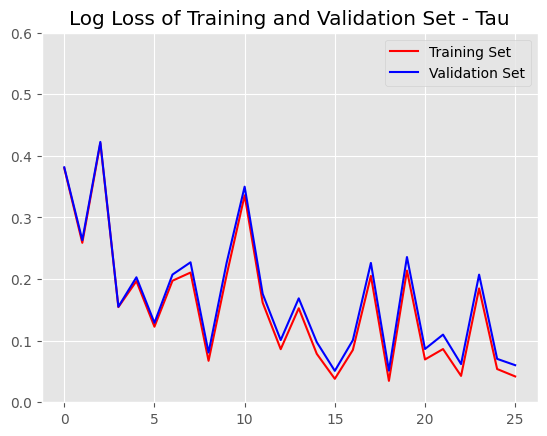

In [36]:
plt.style.use('ggplot')
plt.plot(training_losses, color='red', label='Training Set')
plt.plot(validation_losses, color='blue', label='Validation Set')
# plt.xticks([i for i in range(5, 131, 5)])
plt.legend()
plt.title("Log Loss of Training and Validation Set - Tau")
plt.ylim([0,.6])
plt.show()